In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,top_k_accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import keras 
from glob import glob
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation,Conv2D,MaxPool2D,Flatten,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread, imshow
import pickle
from skimage.transform import resize
from tensorflow.python.keras.models import load_model

2022-11-05 22:20:52.988985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 22:20:53.293229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-05 22:20:53.293277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-05 22:20:53.403487: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-05 22:20:55.360979: W tensorflow/stream_executor/platform/de

In [3]:
s=imread("car2.png")

s=np.array(s).reshape(-1,50,50,3)
s.shape
samples,nx,ny,nz=s.shape
s1=s.reshape(samples,nx*ny*nz)

In [51]:
cnn_model=load_model("breast_cancer_classification_v2_cnn.hdf5")
svm_model=load_model("breast_cancer_svm_classification.hdf5")
random_forrest=model=pickle.load(open("random_forrest.sav","rb"))

In [4]:
cnn_model.predict(s)
svm_model.predict_classes(s)
random_forrest.predict(s1)

/home/hrithik/.local/lib/python3.10/site-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0., 1.]], dtype=float32)

In [18]:
ranf=random_forrest.predict(s1)

In [28]:
read_img=imread("car3.png")
read_img.shape
read_img=read_img.reshape(-1,50,50,3)
read_img.shape
x,y,z,w=read_img.shape
read_img=read_img.reshape(x,y*z*w)
read_img.shape

(1, 7500)

(50, 50, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

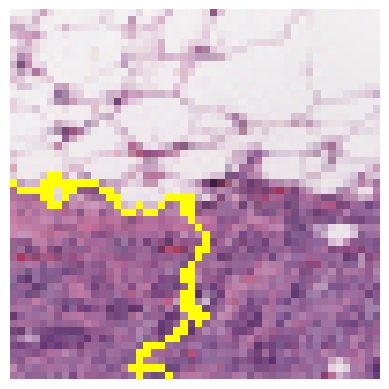

In [62]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
read_img=imread("car8.png")
read_img=resize(read_img,(50,50))
print(read_img.shape)

explainer = lime_image.LimeImageExplainer(random_state=1234)
explanation = explainer.explain_instance(
         read_img, 
         svm_model.predict,
)
plt.axis('off')
plt.imshow(read_img)
image, mask = explanation.get_image_and_mask(
         svm_model.predict(
              read_img.reshape(-1,50,50,3)
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))



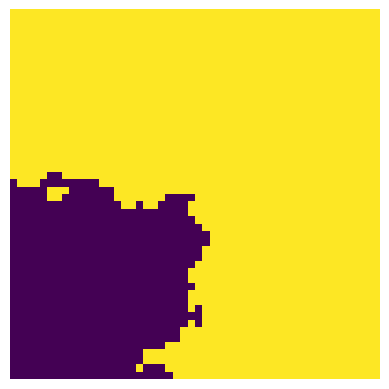

In [64]:
plt.axis('off')
plt.imshow(mask)

In [5]:
file_path=glob("IDC_regular_ps50_idx5/*/*")
class0=[]
class1=[]
for i in file_path:

    h=glob(i+"/"+"*")
    if i.endswith("0"):
        for j in h:
            class0.append(j)
    else:
        for j in h:
            class1.append(j)

    


In [6]:
sample1=random.sample(class0,18786)
sample2=random.sample(class1,18786)

In [7]:
def feature_extract(path,class_name):
    val=[]
    for i in path:
        image_data=imread(i)
        image_size=resize(image_data,(50,50))
        val.append([image_size,class_name])
    
    return val



In [8]:
non_breast_cancer=feature_extract(sample1,"non_breast_cancer")

In [9]:
breast_cancer=feature_extract(sample2,"breast_cancer")

In [10]:
combined_data=np.concatenate((non_breast_cancer,breast_cancer))
random.seed(42)
random.shuffle(combined_data)


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
x=[]
y=[]
for features,class_value in combined_data:
    x.append(features)
    y.append(class_value)

In [12]:
x=np.array(x)


In [13]:
lb=LabelEncoder()
y1=to_categorical(lb.fit_transform(y))
y1

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [14]:
y1.shape

(37572, 2)

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x,y1,test_size=0.26,random_state=42)

In [16]:
samples,nx,ny,nz=x.shape
x1=x.reshape(samples,nx*ny*nz)


In [17]:
y1.shape

(37572, 2)

In [18]:
x_train1,x_test1,y_train1,y_test1=train_test_split(x1,y1,test_size=0.26,random_state=42)

In [19]:

from sklearn.metrics import roc_curve,roc_auc_score
y_preb_cnn=cnn_model.predict_proba(x_test)
y_preb_svm=svm_model.predict_proba(x_test)
y_preb_rf=random_forrest.predict(x_test1)

/home/hrithikpaul/.local/lib/python3.10/site-packages/tensorflow/python/keras/engine/sequential.py:429: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [24]:

auc_keras_cnn =roc_auc_score(y_test,y_preb_cnn)
auc_keras_svm=roc_auc_score(y_test,y_preb_svm)
auc_keras_rf=roc_auc_score(y_test,y_preb_rf)

In [25]:
y1=y_test.flatten()
y2_cnn=y_preb_cnn.flatten()
y2_svm=y_preb_svm.flatten()
y2_rf=y_preb_rf.flatten()

In [26]:
ns_fpr, ns_tpr, _ = roc_curve(y1,y2_cnn)
ns_fpr1,ns_tpr1,_=roc_curve(y1,y2_svm)
ns_fpr2,ns_tpr2,_=roc_curve(y1,y2_rf)

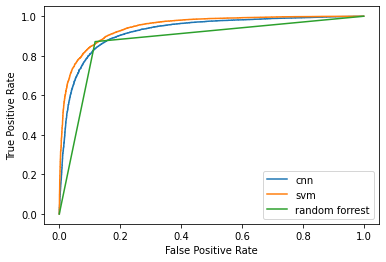

In [27]:
plt.plot(ns_fpr, ns_tpr, linestyle='-', label='cnn')
plt.plot(ns_fpr1, ns_tpr1, linestyle='-', label='svm')
plt.plot(ns_fpr2, ns_tpr2, linestyle='-', label='random forrest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()